In [1]:
import numpy as np
import pywt

import seaborn as sns #绘制confusion matrix heatmap

import sklearn
import os

import tqdm

import time

import warnings

warnings.simplefilter('ignore') #忽略警告

In [2]:
import scipy
import scipy.io as sio

import scipy.signal

from scipy import linalg

import pandas as pd
from sklearn.decomposition import PCA
#分类器
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron

from sklearn.cluster import KMeans

import xgboost
import lightgbm


#模型调节
from mlxtend.feature_selection import SequentialFeatureSelector #特征选择函数 选择合适的feature

#结果可视化
from sklearn.metrics import classification_report , confusion_matrix #混淆矩阵

#相关指标
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import cohen_kappa_score

from sklearn.metrics import roc_auc_score

#二分类其多分类化
#from sklearn.multiclass import OneVsOneClassifier
#from sklearn.multiclass import OneVsRestClassifier

#from sklearn.preprocessing import StandardScaler
#from sklearn.cluster import KMeans

#距离函数 度量向量距离
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity #余弦相似度

#one-hot使用
from keras.utils import to_categorical

from sklearn.preprocessing import label_binarize

#绘图
import matplotlib.pyplot as plt

import scipy.linalg as la

import gc

%matplotlib inline

Using TensorFlow backend.


In [3]:
from mpl_toolkits.mplot3d import Axes3D 

In [4]:
sample_rate = 256 #hz
origin_channel = 16 #5 channel eeg

#采集的通道
#共16 channel
#未使用的channel使用none代替
#reference:a study on performance increasing in ssvep based bci application
SAMPLE_CHANNEL = ['Pz' , 'PO3' , 'PO4' , 'O1' , 'O2' , 'Oz' , 'O9' , 'FP2' ,
                  'C4' , 'C6' , 'CP3' , 'CP1' ,
                  'CPZ' , 'CP2' , 'CP4' , 'PO8']

LABEL2STR = {0:'sen' , 1:'hong' , 2:'zhao',
             3:'fen' , 4:'xiao' , 5:'yu' , 
             6:'bin' , 7:'wang' , 8:'wei' , 
             9:'fei'}

# 减去前多少秒数据 second
# 减去后多少秒数据 second
CLIP_FORWARD = 1
CLIP_BACKWARD = 1

# 单个小段的实验时长
trial_time = 3 #second

#是否进行归一化
#reference:a study on performance increasing in ssvep based bci application
#IS_NORMALIZE = True

#是否进行滤波
#IS_FILTER = False
#EEG频率范围
#reference:a study on performance increasing in ssvep based bci application
LO_FREQ = 0.5
HI_FREQ = 40

#是否陷波
#IS_NOTCH = False
NOTCH_FREQ = 50 #陷波 工频


# 载入数据

In [5]:
def load_data(filename):
    
    data = sio.loadmat(file_name=filename)['data_received'] #length*16 matrix
    
    data = data[CLIP_FORWARD * sample_rate : - CLIP_BACKWARD * sample_rate] #首部 尾部 进行裁剪
    
    return data

In [6]:
def separate(data , label , overlap_length = 128):
    train_data = []
    train_labels = []

    size = sample_rate * trial_time #一小段 256*3 个数据点
    data_length = data.shape[0]
    
    idx = 0

    while idx<data_length-size:
        train_data.append(data[idx : idx+size , :])
        train_labels.append(label)

        idx = idx + (size - overlap_length)

    return np.array(train_data) , np.array(train_labels)

In [7]:
def shuffle_t_v(filenames):
    # np.random.shuffle(filenames)
    
    return np.random.choice(filenames , size=10) #20次的计算准确率中 每次随机选择10个样本进行训练测试

def combine(freq):
    '''
    待定
    '''
    overlap_length = 2*256 #重叠2秒数据
    
    #保证随机性 进行置乱
    person_0_filenames = shuffle_t_v( os.listdir('../incremental/data/base_rf/%s/0/' % freq) )
    person_1_filenames = shuffle_t_v( os.listdir('../incremental/data/base_rf/%s/1/' % freq) )
    person_2_filenames = shuffle_t_v( os.listdir('../incremental/data/base_rf/%s/2/' % freq) )
    person_3_filenames = shuffle_t_v( os.listdir('../incremental/data/base_rf/%s/3/' % freq) )
    person_4_filenames = shuffle_t_v( os.listdir('../incremental/data/base_rf/%s/4/' % freq) )
    person_5_filenames = shuffle_t_v( os.listdir('../incremental/data/base_rf/%s/5/' % freq) )
    person_6_filenames = shuffle_t_v( os.listdir('../incremental/data/base_rf/%s/6/' % freq) )
    person_7_filenames = shuffle_t_v( os.listdir('../incremental/data/base_rf/%s/7/' % freq) )
    person_8_filenames = shuffle_t_v( os.listdir('../incremental/data/base_rf/%s/8/' % freq) )

    #打开信号文件 并 合并
    person_0 = np.concatenate([load_data('../incremental/data/base_rf/%s/0/' % freq + filename) for filename in person_0_filenames] , axis = 0)
    person_1 = np.concatenate([load_data('../incremental/data/base_rf/%s/1/' % freq + filename) for filename in person_1_filenames] , axis = 0)
    person_2 = np.concatenate([load_data('../incremental/data/base_rf/%s/2/' % freq + filename) for filename in person_2_filenames] , axis = 0)
    person_3 = np.concatenate([load_data('../incremental/data/base_rf/%s/3/' % freq + filename) for filename in person_3_filenames] , axis = 0)
    person_4 = np.concatenate([load_data('../incremental/data/base_rf/%s/4/' % freq + filename) for filename in person_4_filenames] , axis = 0)
    person_5 = np.concatenate([load_data('../incremental/data/base_rf/%s/5/' % freq + filename) for filename in person_5_filenames] , axis = 0)
    person_6 = np.concatenate([load_data('../incremental/data/base_rf/%s/6/' % freq + filename) for filename in person_6_filenames] , axis = 0)
    person_7 = np.concatenate([load_data('../incremental/data/base_rf/%s/7/' % freq + filename) for filename in person_7_filenames] , axis = 0)
    person_8 = np.concatenate([load_data('../incremental/data/base_rf/%s/8/' % freq + filename) for filename in person_8_filenames] , axis = 0)
    
    #============
    #训练数据分段
    train_person_data_0 , train_person_labels_0 = separate(person_0 , label = 0 , overlap_length=overlap_length)
    train_person_data_1 , train_person_labels_1 = separate(person_1 , label = 1 , overlap_length=overlap_length)
    train_person_data_2 , train_person_labels_2 = separate(person_2 , label = 2 , overlap_length=overlap_length)
    train_person_data_3 , train_person_labels_3 = separate(person_3 , label = 3 , overlap_length=overlap_length)
    train_person_data_4 , train_person_labels_4 = separate(person_4 , label = 4 , overlap_length=overlap_length)
    train_person_data_5 , train_person_labels_5 = separate(person_5 , label = 5 , overlap_length=overlap_length)
    train_person_data_6 , train_person_labels_6 = separate(person_6 , label = 6 , overlap_length=overlap_length)
    train_person_data_7 , train_person_labels_7 = separate(person_7 , label = 7 , overlap_length=overlap_length)
    train_person_data_8 , train_person_labels_8 = separate(person_8 , label = 8 , overlap_length=overlap_length)

    #合并数据
    train_data = np.concatenate((train_person_data_0 , train_person_data_1 , train_person_data_2 ,
                                 train_person_data_3 , train_person_data_4 , train_person_data_5 ,
                                 train_person_data_6 , train_person_data_7 , train_person_data_8 ,
                                 ))
    
    train_labels = np.concatenate((train_person_labels_0 , train_person_labels_1 , train_person_labels_2 ,
                                   train_person_labels_3 , train_person_labels_4 , train_person_labels_5 ,
                                   train_person_labels_6 , train_person_labels_7 , train_person_labels_8 ,
                                    ))
    
    #产生索引并置乱
    idx_train_data = list(range(train_data.shape[0]))
    np.random.shuffle(idx_train_data)

    #将训练数据置乱
    train_data = train_data[idx_train_data]
    train_labels = train_labels[idx_train_data]
        
    return train_data , train_labels


In [8]:
def butter_worth(data , lowcut , highcut , order=6):
    nyq = 0.5 * sample_rate
    
    lo = lowcut / nyq
    hi = highcut / nyq
    
    b,a = scipy.signal.butter(order , [lo , hi] , btype='bandpass')

    return np.array([scipy.signal.filtfilt(b , a , data[: , i]) for i in range(data.shape[1])]).reshape((-1 , origin_channel))

def alpha_subBP_features(data):
    alpha1 = butter_worth(data , 8.5 , 11.5)
    alpha2 = butter_worth(data , 9.0 , 12.5)    
    alpha3 = butter_worth(data , 9.5 , 13.5)   #11.5 后
    alpha4 = butter_worth(data , 8.0 , 10.5)   
    
    return np.array([alpha1 , alpha2 , alpha3 , alpha4])

def beta_subBP_features(data):
    beta1 = butter_worth(data , 15.0 , 30.0) #14.0 前
    beta2 = butter_worth(data , 16.0 , 17.0)    
    beta3 = butter_worth(data , 17.0 , 18.0)    
    beta4 = butter_worth(data , 18.0 , 19.0)    
    
    return np.array([beta1 , beta2 , beta3 , beta4])

def powermean(data):
    #官方demo跳4秒 前4秒为准备阶段
    return  np.power(data[ : , 0] , 2).mean(), \
            np.power(data[ : , 1] , 2).mean(), \
            np.power(data[ : , 2] , 2).mean(), \
            np.power(data[ : , 3] , 2).mean(), \
            np.power(data[ : , 4] , 2).mean(), \
            np.power(data[ : , 5] , 2).mean(), \
            np.power(data[ : , 6] , 2).mean(), \
            np.power(data[ : , 7] , 2).mean(), \
            np.power(data[ : , 8] , 2).mean(), \
            np.power(data[ : , 9] , 2).mean(), \
            np.power(data[ : , 10] , 2).mean(), \
            np.power(data[ : , 11] , 2).mean(), \
            np.power(data[ : , 12] , 2).mean(), \
            np.power(data[ : , 13] , 2).mean(), \
            np.power(data[ : , 14] , 2).mean(), \
            np.power(data[ : , 15] , 2).mean()      
            
def log_subBP_feature_extraction(alpha , beta):
    #alpha
    power_1_a = powermean(alpha[0])
    power_2_a = powermean(alpha[1])
    power_3_a = powermean(alpha[2])
    power_4_a = powermean(alpha[3])
    
    #beta
    power_1_b = powermean(beta[0])
    power_2_b = powermean(beta[1])
    power_3_b = powermean(beta[2])
    power_4_b = powermean(beta[3])
    
    X= np.array(
        [np.log(power_1_a) ,
         np.log(power_2_a) ,
         np.log(power_3_a) ,
         np.log(power_4_a) ,
         np.log(power_1_b) ,
         np.log(power_2_b) ,
         np.log(power_3_b) ,
         np.log(power_4_b)
        ]
        ).flatten()

    return X

def feature_extraction_sub_band_power(data):
    n_features = 128
    X = np.zeros((data.shape[0] , n_features))
    
    for i , datum in enumerate(data):
        alpha = alpha_subBP_features(datum)
        beta = beta_subBP_features(datum)
            
        X[i, :] = log_subBP_feature_extraction(alpha , beta)

    return X

In [9]:
def session_data_labels(session_id , freq , is_training):
    '''
    执行一次 返回一个session的所有受试者的脑电信息
    '''
    if is_training:
        overlap_length = 256*2
    else:
        overlap_length = 0
    
    str_freq = str(freq)
    
    subjcets = os.listdir('../incremental/data/incremental/%s/s%d/' % (str_freq , session_id)) #受试者ID
    
    data = []
    labels = []
    
    for subjcet in subjcets:
        filenames = os.listdir('../incremental/data/incremental/%s/s%d/%s/' % (str_freq , session_id , subjcet))
        
        person = np.concatenate([load_data('../incremental/data/incremental/%s/s%d/%s/%s' % (str_freq , session_id , subjcet , filename)) for filename in filenames] , axis = 0)
        
        person_data , person_label = separate( person , label = int(subjcet) , overlap_length = overlap_length)
        
        data.append(person_data)
        labels.append(person_label)
    
    #合并数据
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    
    #shuffle数据置乱
    idx_data = list(range(data.shape[0]))
    np.random.shuffle(idx_data)

    data = data[idx_data]
    labels = labels[idx_data]
    
    return data , labels


In [70]:
def subject_data_labels(session_id , freq , subject_id , is_training):
    '''
    执行一次 返回一个受试者的一个session的指定频率的脑电数据
    '''
    if is_training:
        overlap_length = 256*2
    else:
        overlap_length = 0
    
    str_freq = str(freq)
    
    subjcet = str(subject_id)
    
    filenames = os.listdir('../incremental/data/incremental/%s/s%d/%s/' % (str_freq , session_id , subjcet))

    person = np.concatenate([load_data('../incremental/data/incremental/%s/s%d/%s/%s' % (str_freq , session_id , subjcet , filename)) for filename in filenames] , axis = 0)

    data , labels = separate( person , label = subject_id , overlap_length = overlap_length)

    #shuffle数据置乱
    idx_data = list(range(data.shape[0]))
    np.random.shuffle(idx_data)

    data = data[idx_data]
    labels = labels[idx_data]
    
    return data , labels


In [10]:
def concat_and_shuffle(orig_X , orig_y , session_id , freq):
    session_id_data , session_id_labels = session_data_labels(session_id , freq , is_training=True)
    session_id_data = feature_extraction_sub_band_power(session_id_data)
    # session_id_labels = to_categorical(session_id_labels , num_classes=9)
    
    orig_X = np.concatenate((orig_X , session_id_data) , axis=0)
    orig_y = np.concatenate((orig_y , session_id_labels) , axis=0)
    
    idx = list(range(orig_X.shape[0]))
    np.random.shuffle(idx)
    
    orig_X = orig_X[idx]
    orig_y = orig_y[idx]
    
    return orig_X , orig_y

# PCA降维

In [11]:
def cal_time(ss):
    #step = ss[1]-ss[0]
    
    for i in range(1,len(ss)):
        r_v = np.random.choice([np.random.random()*(-0.05) , np.random.random()*0.05])
        #print(r_v)
        ss[i] = ss[0] + r_v
    return ss


for freq in [6 , 7.5 , 8.5 , 10]:
    print('freq = ' , freq)
    
    times = []
    accus = []
        
    times_sub = []
    accus_sub = []

    for idx , session_id in enumerate([1,3,5,6,7,8,9,11,12,13]):
        train_X , train_y = session_data_labels(session_id , freq , is_training=True)
        train_X = feature_extraction_sub_band_power(train_X) #SBP特征提取

        pca = PCA(n_components=2)
        
        start = time.clock()
        pca_train_X = pca.fit(train_X).transform(train_X)
        decomp_time = time.clock() - start
        

        accus_sub.append(score)

        #print( freq , session_id , score)

        #更新模型
        train_X , train_y = concat_and_shuffle(train_X , train_y , session_id , freq)

        rf = RandomForestClassifier(n_estimators=16)

        start = time.clock()
        rf.fit(train_X , train_y)
        time2 = time.clock() - start

        times_sub.append(time1 + time2)

    times_sub = cal_time(times_sub)
    #print(times_sub)

    times.append(times_sub)
    accus.append(accus_sub)

times = np.array(times)
accus = np.array(accus)

print('aver time : ' , list(map(np.mean , times.T )) )
print('aver accu : ' , list(map(np.mean , accus.T )) )

freq =  6


KeyboardInterrupt: 

In [80]:
def get_center(data , label):
    centers = []
    
    for label_id in range(9): #一共9个受试者
        equal_idx = np.where(label == label_id)
    
        center = np.mean(data[equal_idx] , axis = 0)
        centers.append(center)
        
    return np.array(centers)

def get_center_simple(data):
    '''
    计算单个用户的脑电的中心
    '''
    return np.mean(data , axis=0)

In [82]:
X , y = subject_data_labels(1,6,0,is_training=True)
X_sbp = feature_extraction_sub_band_power(X)

In [83]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)

In [81]:
get_center_simple(X_pca) #1

array([ 2.59322166e-16, -3.11186600e-16])

In [93]:
coord_0 = []

for session_id in [1,3,5,6,7,8,9,11,12,13]:
    X , y = subject_data_labels(session_id,6,0,is_training=True)
    X_sbp = feature_extraction_sub_band_power(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_sbp)
    coord_0.append(get_center_simple(X_pca))

coord_0 = np.array(coord_0)

In [94]:
coord_1 = []

for session_id in [1,3,5,6,7,8,9,11,12,13]:
    X , y = subject_data_labels(session_id,6,1,is_training=True)
    X_sbp = feature_extraction_sub_band_power(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_sbp)
    coord_1.append(get_center_simple(X_pca))
    
coord_1 = np.array(coord_1)

In [99]:
coord_2 = []

for session_id in [1,3,5,6,7,8,9,11,12,13]:
    X , y = subject_data_labels(session_id,6,2,is_training=True)
    X_sbp = feature_extraction_sub_band_power(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_sbp)
    coord_2.append(get_center_simple(X_pca))
    
coord_2 = np.array(coord_2)

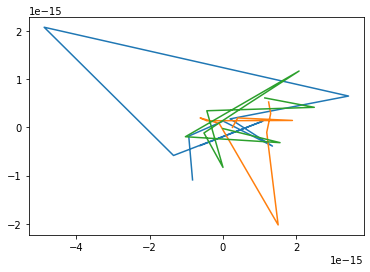

In [100]:
plt.plot(coord_0[:,0] , coord_0[:,1])
plt.plot(coord_1[:,0] , coord_1[:,1])
plt.plot(coord_2[:,0] , coord_2[:,1])

In [47]:
kmeans = KMeans(n_clusters=9)

In [48]:
kmeans.fit_transform(X_pca)

array([[ 6.27227019, 57.83362014, 31.2335285 , ...,  1.52628227,
         5.01729422, 25.5861187 ],
       [ 2.79494641, 54.91876481, 28.60344437, ...,  7.64828728,
         6.17348677, 20.14750927],
       [ 4.76648756, 57.83480064, 31.74733799, ...,  9.34190989,
         9.39515478, 22.60252282],
       ...,
       [ 7.34062797, 50.11323649, 23.47858398, ...,  8.02981234,
         3.18825101, 17.73721787],
       [ 7.56353667, 60.77693056, 34.17370954, ...,  3.04406411,
         7.77834829, 28.30187471],
       [ 3.05300917, 53.80841065, 27.4200052 , ...,  7.43637749,
         5.14104231, 19.27321459]])

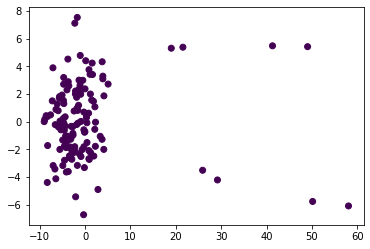

In [51]:
plt.scatter(X_pca[:,0] , X_pca[:,1] , c=y)

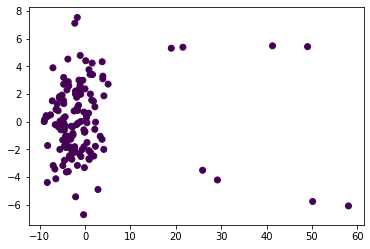

In [57]:
X , y = subject_data_labels(1,6,0,is_training=True)
X_sbp = feature_extraction_sub_band_power(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)
plt.scatter(X_pca[:,0] , X_pca[:,1] , c=y)

In [ ]:
X , y = subject_data_labels(1,6,0,is_training=True)
X_sbp = feature_extraction_sub_band_power(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)
plt.scatter(X_pca[:,0] , X_pca[:,1] , c=y)

In [22]:
kmeans.fit_transform(X_pca)

array([[ 7.29905911, 23.66831502, 33.07445352, ..., 11.99958477,
        12.78444324, 43.8456855 ],
       [ 9.02382509, 39.62568772, 49.02691329, ...,  3.9610635 ,
        28.67884733, 59.79950353],
       [31.98872294,  2.48850027,  8.31047681, ..., 36.97883111,
        12.98754391, 18.99315102],
       ...,
       [ 8.30891347, 37.43982538, 46.8500046 , ...,  3.78632228,
        26.28566694, 57.59143959],
       [ 7.90884323, 38.30518298, 47.71392771, ...,  2.70475125,
        27.30694676, 58.48421919],
       [32.46464591,  1.78781165,  7.85966066, ..., 37.31293799,
        12.74393485, 18.57503321]])

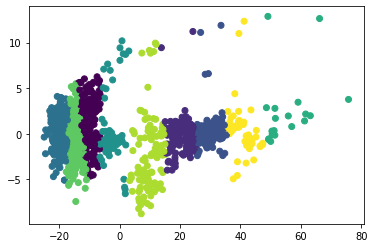

In [23]:
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=kmeans.labels_)

In [24]:
kmeans.cluster_centers_

array([[ -9.9410088 ,   1.24178122],
       [ 20.80396199,  -0.28127865],
       [ 30.20082363,   0.30050634],
       [-19.39492352,   0.19410413],
       [ -2.51519861,   0.27101596],
       [ 54.98741879,   2.23497923],
       [-14.86235088,  -0.47761388],
       [  9.78349403,  -2.4141317 ],
       [ 40.97356369,   0.35700965]])

In [ ]:
for freq in [6 , 7.5 , 8.5 , 10]:
    for session_id in [1 , 3 , 5 , 6 , 7 , 8 , 9 , 11 , 12 , 13]:
        
        X , y = session_data_labels(session_id , freq , is_training=True)
        X_sbp = feature_extraction_sub_band_power(X)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_sbp)
        plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=y)

# session 1 
# 6 7.5 8.5 10 hz
# 只降维 未聚类

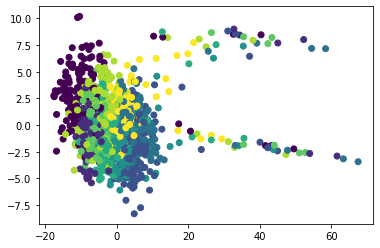

In [126]:
X , y = session_data_labels(1 , 6 , is_training=True)
X_sbp = feature_extraction_sub_band_power(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=y)

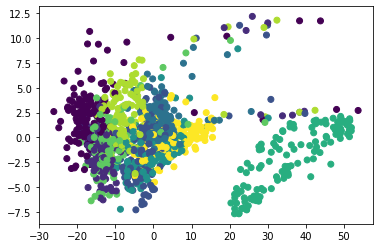

In [105]:
X , y = session_data_labels(1 , 7.5 , is_training=True)
X_sbp = feature_extraction_sub_band_power(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=y)

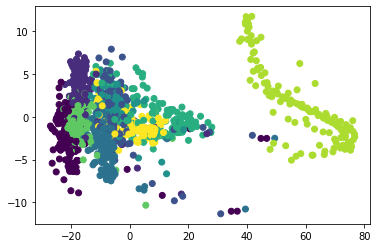

In [106]:
X , y = session_data_labels(1 , 8.5 , is_training=True)
X_sbp = feature_extraction_sub_band_power(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=y)

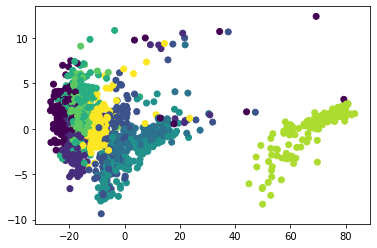

In [107]:
X , y = session_data_labels(1 , 10 , is_training=True)
X_sbp = feature_extraction_sub_band_power(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=y)

# session 2 
# 6 7.5 8.5 10 hz
# 只降维 未聚类

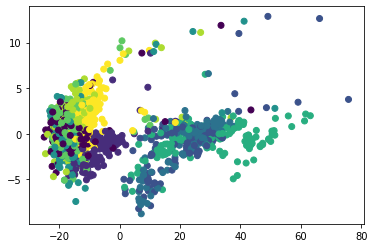

In [108]:
X , y = session_data_labels(2 , 6 , is_training=True)
X_sbp = feature_extraction_sub_band_power(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=y)

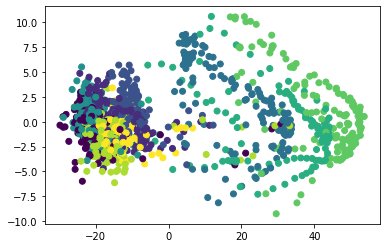

In [109]:
X , y = session_data_labels(2 , 7.5 , is_training=True)
X_sbp = feature_extraction_sub_band_power(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=y)

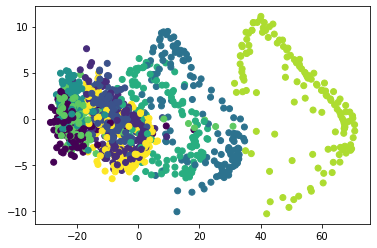

In [110]:
X , y = session_data_labels(2 , 8.5 , is_training=True)
X_sbp = feature_extraction_sub_band_power(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=y)

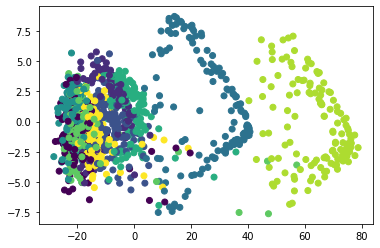

In [117]:
X , y = session_data_labels(2 , 10 , is_training=True)
X_sbp = feature_extraction_sub_band_power(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbp)
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=y)

In [119]:
centers = get_center(X_pca , y)

In [120]:
centers


array([[-18.80992126,  -1.20134835],
       [ -9.99794526,   1.2444652 ],
       [ -7.27128138,  -0.34673496],
       [ 25.134028  ,   1.17662342],
       [-21.34934414,   0.3919315 ],
       [ -1.84228848,   0.91937017],
       [-16.14723251,  -0.99553461],
       [ 63.40545912,  -0.29149362],
       [-13.12147409,  -0.89727873]])

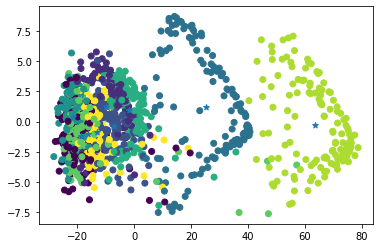

In [124]:
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=y)
plt.scatter(centers[:,0] , centers[:,1]  , marker='*')

# 下面是聚类举例

In [114]:
kmeans = KMeans(n_clusters=9)
res = kmeans.fit_transform(X_pca)

In [115]:
res.shape

(1233, 9)

In [116]:
X_pca.shape

(1233, 2)

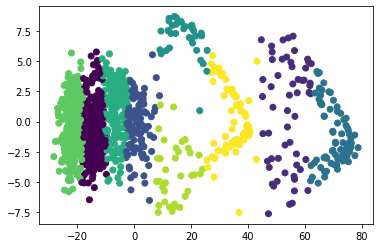

In [113]:
plt.scatter(X_pca[: , 0] , X_pca[: , 1] , c=kmeans.labels_)